<a href="https://colab.research.google.com/github/Xiaolumang/SIT_796_RL/blob/main/task_7_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3) code

In [ ]:
# !pip install -q --upgrade ipython
# !pip install -q --upgrade ipykernel

In [ ]:
!pip install gym==0.17.3

In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [ ]:
from numpy.core.numerictypes import sctype2char
class tile_encoding:
  def __init__(self, numTilings, tiles1d):
    self.maxIn = env.observation_space.high
    self.minIn = env.observation_space.low
    self.numTilings = numTilings
    self.tiles1d = tiles1d
    self.dim = len(self.minIn)
    self.numTiles = (self.tiles1d**self.dim)*self.numTilings
    self.actions = env.action_space.n
    self.total_tiles = self.numTiles * self.actions
    self.tileSize = np.divide(np.subtract(self.maxIn, self.minIn), self.tiles1d-1)
    
  
  def featurize_state_action(self, state, action):
    tileIndices = self.getFeatures(state)
    features = []
    for i in tileIndices:
      index = int(i+ self.numTiles*action)
      features.append(index)
    return np.array(features)

  def getFeatures(self, variables):
    self.variables = np.subtract(variables, self.minIn)
    tileIndices = np.zeros(self.numTilings)
    matrix = np.zeros([self.numTilings, self.dim])
    for i in range(self.numTilings):
      for i2 in range(self.dim):
        matrix[i, i2] = int(self.variables[i2]/self.tileSize[i2] + i/self.numTilings)

    for i in range(1, self.dim):
      matrix[:,i] *= self.tiles1d ** i
   
    for i in range(self.numTilings):
      tileIndices[i] = (i*(self.tiles1d ** self.dim) + sum(matrix[i,:]))
    return tileIndices



class Model:
  def __init__(self, action_num, trace= False):
    self.trace = trace
    np.random.seed(0)
    self.theta = np.random.uniform(-0.001,0, size=(tile.total_tiles))
    self.alpha = 1/tile.numTilings
    self.action_num = action_num
  
  def reset(self, z_only):
    if z_only:
      self.z = np.zeros(tile.total_tiles)
    else:
      if self.trace:
        self.z = np.zeros(tile.total_tiles)
      np.random.seed(0)
      self.theta = np.random.uniform(-0.001,0, size=(tile.total_tiles))

  def predict(self, s, a=None):
    if a is not None:
      return np.sum(self.theta[tile.featurize_state_action(s,a)])
    else:
      rst = [np.sum(self.theta[tile.featurize_state_action(s,a)])  for a in range(self.action_num) ]
      return rst
    

  def grad(self, s, a):
    grad = np.zeros(len(self.theta))
    features = tile.getFeatures(s) + tile.numTiles*a
    for x in features:
      grad[int(x)] = 1
    
    return grad
  
  def update(self, state, action, target):
    features = tile.featurize_state_action(state, action)
    estimation = np.sum(self.theta[features])
   # print('theta ', np.sum(self.theta))
    delta = target - estimation
    if self.trace:
     # self.z[features] = 1
      # update all states
      self.theta += self.alpha *delta * self.z*self.grad(state,action)
      #self.theta += 0.1/episode *delta * self.z*self.grad(state,action)
    else:
      # update using tile coding
      self.theta += self.alpha * delta*self.grad(state,action)
      #model.theta += model.alpha *(r + gamma * maxQs2a2 - model.predict(state, action))*model.grad(state,action)


  # def getVal(self, theta, features, action):
  #   val = 0
  #   for i in features:
  #     index = int(i+self.numTiles*action)
  #    # print(i, index, len(theta))
  #     val += theta[index]
  #   return val

def epsilon_greedy_policy(model, epsilon, num_actions):
  def policy(state):
    action_probs = np.ones(num_actions, dtype=float) * epsilon/num_actions
    q_values = model.predict(state)
    best_action_index = np.argmax(q_values)
    action_probs[best_action_index] += 1- epsilon
    return action_probs

  return policy


def train_model( model,env, gamma, epsilon,lmda=0.7,sarsa_lambda=False):
 
  # sarsa lambda set eligibility to 0 for all states
  if sarsa_lambda is True:
    model.reset(True)
 # print(model.z)
  
  policy = epsilon_greedy_policy(model, epsilon,env.action_space.n)
  
  state = env.reset()
  action_probs = policy(state)
  action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
  
  for i in range(200):
      next_s, r, done, _ = env.step(action)
      if done:
        model.update(state,action, r)
        break
      else:
        next_action_probs = policy(next_s)
        next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)
        q_new = model.predict(next_s, next_action)
        #print('q_new ',q_new, next_s, next_action)
        target = r + gamma * q_new
        if sarsa_lambda is True:
          model.z = model.z * gamma * lmda + model.grad(state,action)
        #  print(model.z)
        #print(model.theta)
        model.theta += model.alpha *(r + gamma * q_new - model.predict(state, action))*model.grad(state,action)

       # model.update(state, action, target)
      
      state = next_s
      action = next_action

In [ ]:
# install required system dependencies
# install required system dependencies
!sudo apt-get install -y xvfb x11-utils 
!sudo apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+4).
xvfb is already the newest version (2:1.20.4-1+deb10u4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [ ]:

import base64
import io
import IPython
from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display
import gym

def run_model(model, display=False):
  env = gym.make('MountainCar-v0')
  action_num = env.action_space.n
  if display:
    d = Display()
    d.start()

    env = gym.make('MountainCar-v0')
    env = Monitor(env,'./vid',force=True)

  state = env.reset()
  rewards =0
  for step in range(1,300):
    policy = epsilon_greedy_policy(model, 0,action_num)
    action_probs = policy(state)
    action = np.argmax(action_probs)
    state, r, done, _ = env.step(int(action))
    rewards += r
    if done:
      state = env.reset()
     # print(f'episode ends in {step} steps')
      break
  return env, rewards

def show_videos(env):
  for f in env.videos:
 
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))


In [ ]:
label_1 = 'rewards per episode'
label_2 = 'average reward of 100 episodes'

## Sarsa(0)

In [ ]:
def run_episodes(model, episodes=100):
  total_rewards_per_episode = []
  for i in range(100):
    # if i % 20 == 0:
    #   print(f'{i} episode')
    env,rewards = run_model(model)
    total_rewards_per_episode.append(rewards)
  return total_rewards_per_episode

def plot_episodes(total_rewards_per_episode):
  plt.plot(range(100), total_rewards_per_episode, label=label_1)
  average_total = np.mean(total_rewards_per_episode)
  plt.plot([average_total]*100,label=label_2)
  plt.legend()
  print('the average reward is ',average_total)  


In [ ]:
gamma = 0.9

numEpisodes = 10000

epsilon = 0.1
env = gym.make('MountainCar-v0')
tile = tile_encoding(4, 18)

In [ ]:
model_sarsa_0 = Model(env.action_space.n, trace =False)

for episode in range(1, numEpisodes+1):
  if episode %2000 == 0:
    print(episode)
  train_model( model_sarsa_0,env, gamma, epsilon,None,False)
  epsilon = 0.95 * epsilon


2000
4000
6000
8000
10000


the average reward is  -181.09


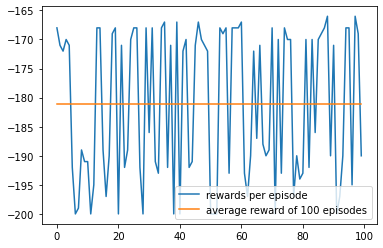

In [ ]:
total_rewards_per_episode_sarsa_0 = run_episodes(model_sarsa_0)
plot_episodes(total_rewards_per_episode_sarsa_0)

In [ ]:
# show video for one episode
!rm ./vid/*.*
env,rewards = run_model(model_sarsa_0,True)
show_videos(env)

## Sarsa lambda, lambda=0.3

In [ ]:
def Sarsa_lambda(lmda):
  gamma = 0.9
  numEpisodes = 10000
  lmda = lmda
  epsilon = 0.1
  env = gym.make('MountainCar-v0')
  tile = tile_encoding(4, 18)
  model_sarsa_lambda = Model(env.action_space.n,trace=True)

  for episode in range(1,numEpisodes+1):
    if episode %2000 == 0:
      print(episode)
    train_model( model_sarsa_lambda,env, gamma, epsilon,lmda,True)
    epsilon = 0.95 * epsilon
  return model_sarsa_lambda




In [ ]:
model_sarsa_0_3 = Sarsa_lambda(0.3)


2000
4000
6000
8000
10000
12000
14000


the average reward is  -169.45


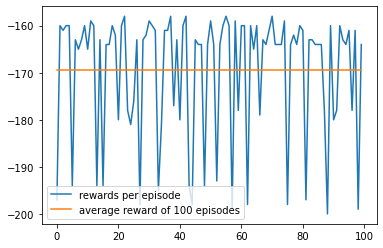

In [ ]:
total_rewards_per_episode_sarsa_1 = run_episodes(model_sarsa_0_3)
plot_episodes(total_rewards_per_episode_sarsa_1)

In [ ]:
!rm ./vid/*.*
env, _ = run_model(model_sarsa_0_3, True)
show_videos(env)

## Sarsa lambda, lambda=0.7


In [ ]:
model_sarsa_0_7 = Sarsa_lambda(0.7)


2000
4000
6000
8000
10000


the average reward is  -145.5


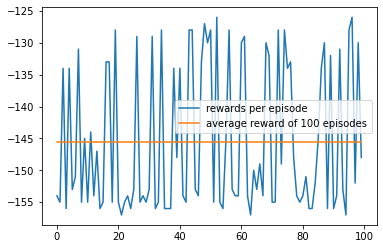

In [ ]:
total_rewards_per_episode_sarsa_2 = run_episodes(model_sarsa_0_7)
plot_episodes(total_rewards_per_episode_sarsa_2)

In [ ]:
!rm ./vid/*.*
env, _ = run_model(model_sarsa_0_7, True)
show_videos(env)

## Sarsa lambda, lambda=0


In [ ]:
model_sarsa_0_0 = Sarsa_lambda(0)


2000
4000
6000
8000
10000
12000
14000


the average reward is  -160.19


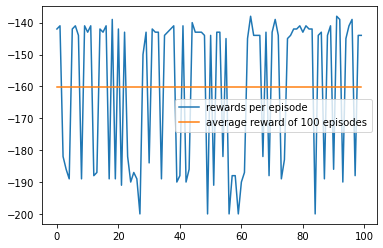

In [ ]:
total_rewards_per_episode_sarsa_3 = run_episodes(model_sarsa_0_0)
plot_episodes(total_rewards_per_episode_sarsa_3)

In [ ]:
!rm ./vid/*.*
env, _ = run_model(model_sarsa_0_0, True)
show_videos(env)